# Predicting Rainfall Anomalies in the Amazon
## Model Outline:
- Preprocessing
- Multivariate EOF
- Ridge Regression
- Lasso Regression
- Neural Network Regression

Created by David Gotler, 2021

## Preprocessing
### Define a dataframe class to:
- Load in the datasets:
    - feature dataset (ERA5): variables are CAPE, CIN, geopotential, relative humidity
        - lat: (0,-30), lon: (-40,-80)
    - target dataset (GPCC): variable is precipitation
        - lat: (-5,-20), lon: (-45,-65)
- Detrend the dataset by removing linear trends. We want the dataset to be stationary
- Calculate standardized anomalies by subtracting the monthly mean and dividing by standard deviation. We want centered dataset with unit variance.

In [1]:
import numpy as np
import xarray as xr

from matplotlib import pyplot as plt
# import holoviews as hv
# import hvplot.xarray
# hv.extension('bokeh')

import dataframe
import forecast
from forecast import get_dataset
from forecast import DirectForecaster,RecursiveForecaster

from importlib import reload

In [26]:
reload(dataframe)
from dataframe import dataframe as df

# directories
features_fname = 'ERA5.features.1950-2019.nc'
target_fname = 'precip.mon.total.1x1.v2020.nc'

# input regions
lat_ft = -30,0
lon_ft = -80,-40

lat_t = -20,-5
lon_t = -65,-45

yrs = 1950,2019
# pack tuple
range_ft =  lat_ft+lon_ft+yrs
range_t = lat_t+lon_t+yrs

# Create df object to store our feature and target datasets
data = df(features_fname,target_fname,features_range=range_ft,target_range=range_t)
data.detrend()
data.std_anom()
data.flatten()
data.remove_nan()

TypeError: __init__() got an unexpected keyword argument 'features_range'

## Linear Regression
Direct forecasting using linear regression.

In [6]:
reload(forecast)
from forecast import DirectForecaster,RecursiveForecaster

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
forecaster = DirectForecaster(LinearRegression(),lags=3,target_months=[9,10,11],steps=3,include_autoreg=True,avg_lags=True,pca_features=True)
X_train,y_train,X_test,y_test = forecaster.train_test_split(4,data.target_da,data.features_da)
forecaster.fit(X_train,y_train)

y_pred = forecaster.predict(X_test,y_test)

weights = np.abs(np.cos(np.deg2rad(y_test.lat.values)))
print('mean absolute error on the test set: {:.3f}'.format(mean_absolute_error(y_test,y_pred,multioutput=weights)))

y_true_ds = get_dataset(y_test)
y_pred_ds = get_dataset(y_pred)
forecaster.data_plots(y_true_ds,y_pred_ds,model_name='linear',forecaster_name='direct_pca',individual=True,plot_facet=True,plot_timeseries=True,plot_corr_map=True,plot_error=True)

mean absolute error on the test set: 0.725


AttributeError: 'DirectForecaster' object has no attribute 'data_plots'

## Ridge Regression
Direct forecasting using linear regression with L2 (ridge) regularization.

mean absolute error on the test set: 0.762


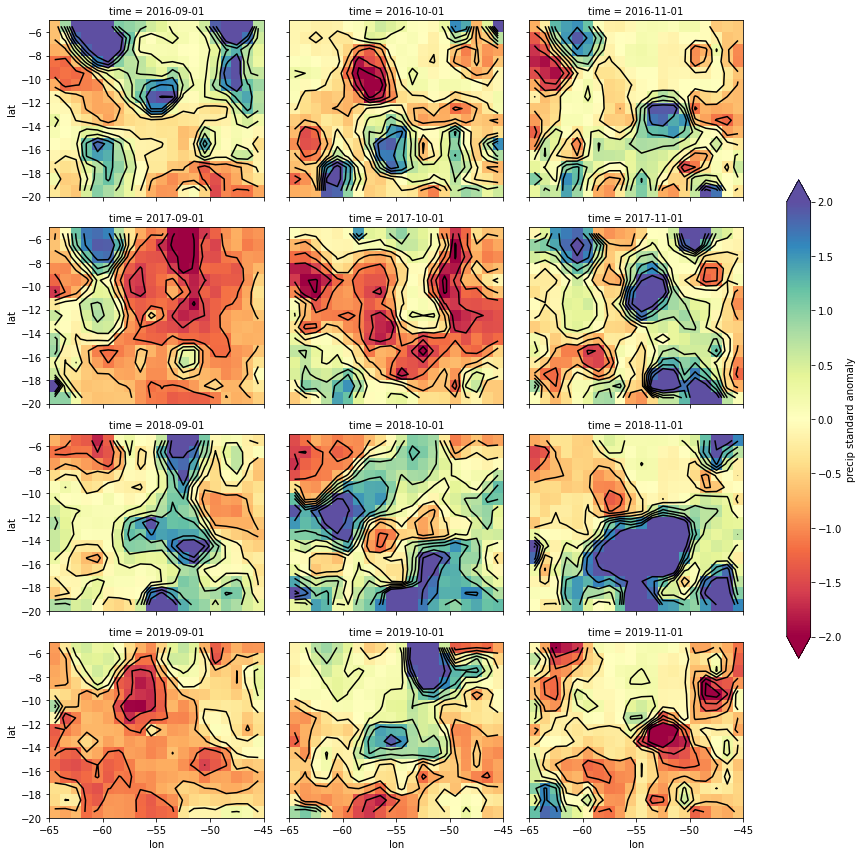

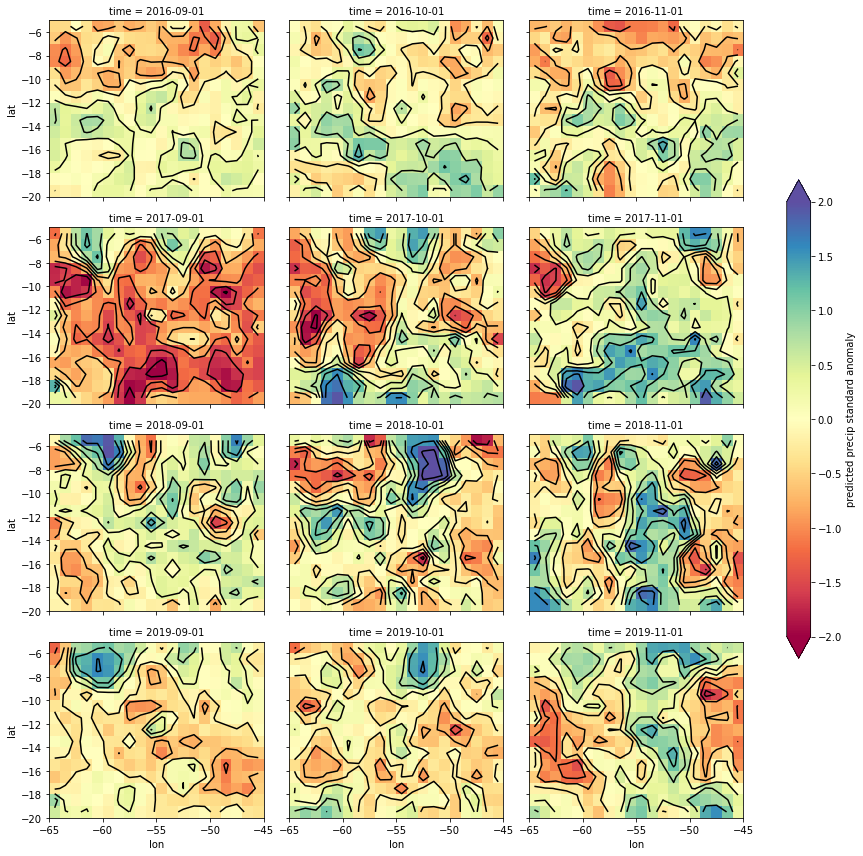

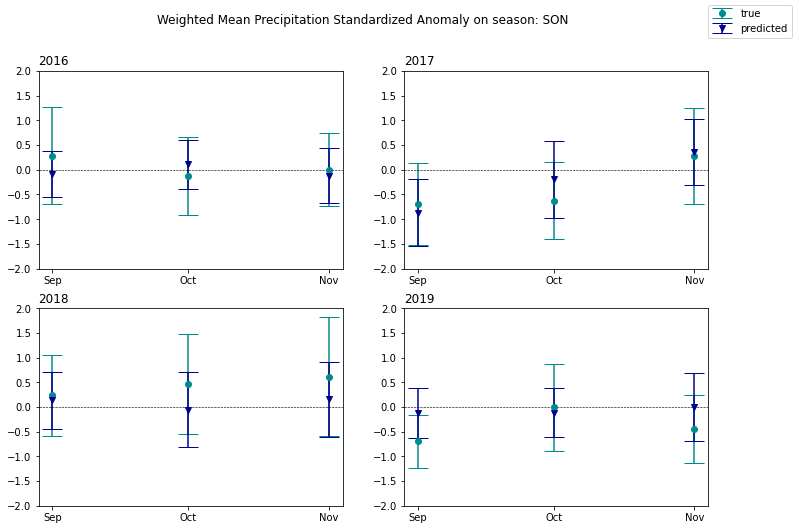

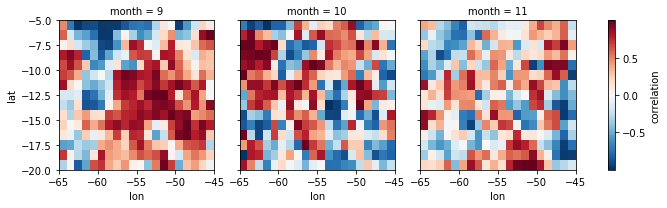

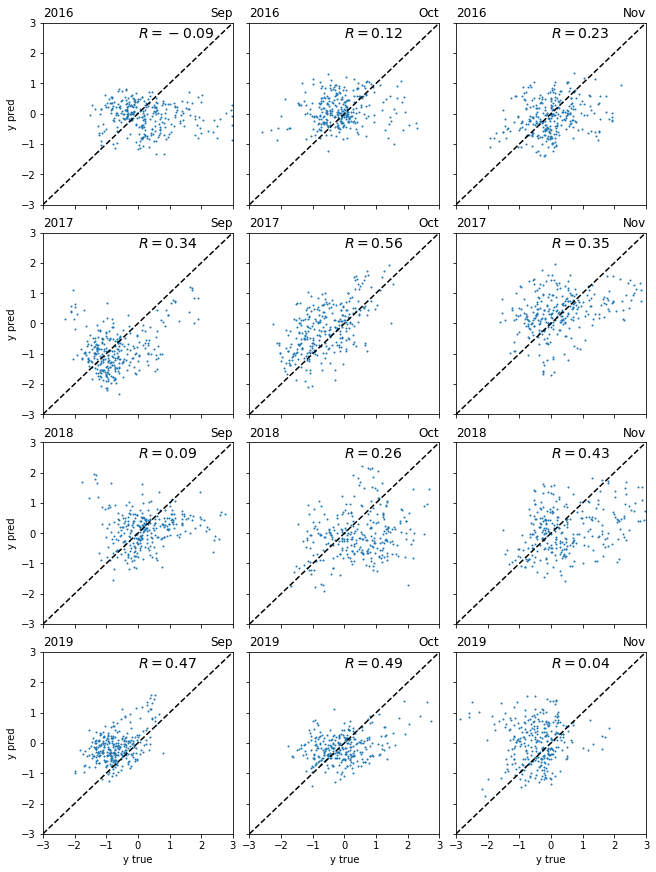

In [29]:
from sklearn.linear_model import Ridge

forecaster = DirectForecaster(Ridge(alpha=100),lags=3,target_months=[9,10,11],steps=3,include_autoreg=True,avg_lags=True,pca_features=False)
X_train,y_train,X_test,y_test = forecaster.train_test_split(4,data.target_da,data.features_da)
forecaster.fit(X_train,y_train)

y_pred = forecaster.predict(X_test,y_test)
weights = np.abs(np.cos(np.deg2rad(y_test.lat.values)))

print('mean absolute error on the test set: {:.3f}'.format(mean_absolute_error(y_test,y_pred,multioutput=weights)))

y_true_ds = get_dataset(y_test)
y_pred_ds = get_dataset(y_pred)
forecaster.data_plots(y_true_ds,y_pred_ds,model_name='ridge',forecaster_name='direct',individual=True,plot_facet=True,plot_timeseries=True,plot_corr_map=True,plot_error=True)

## Lasso Regression

mean absolute error on the test set: 0.724


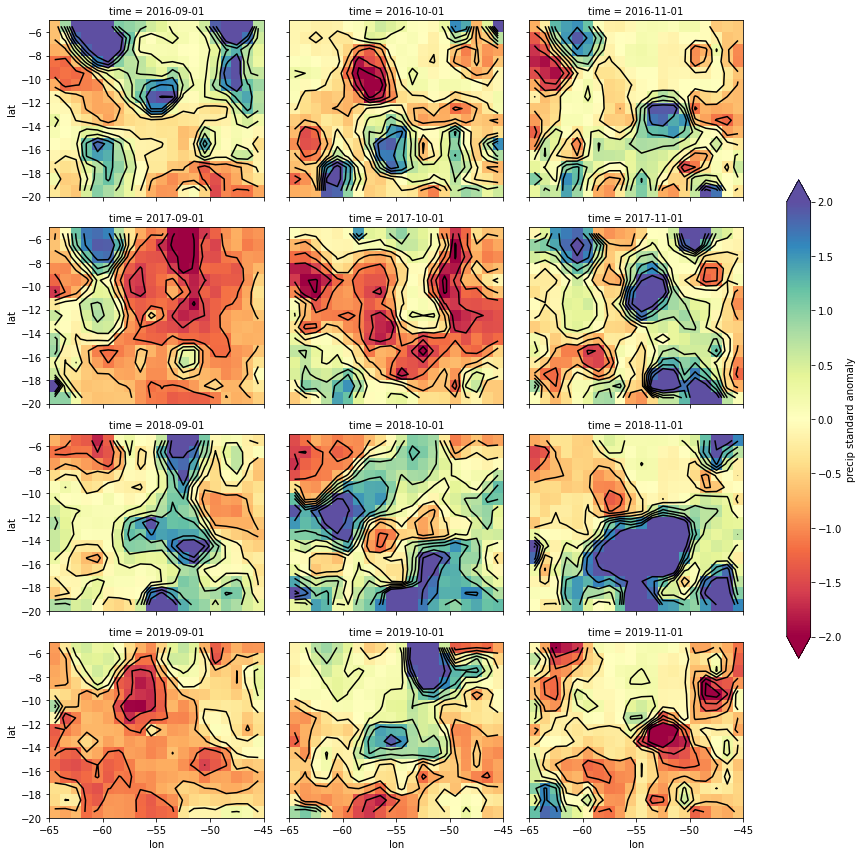

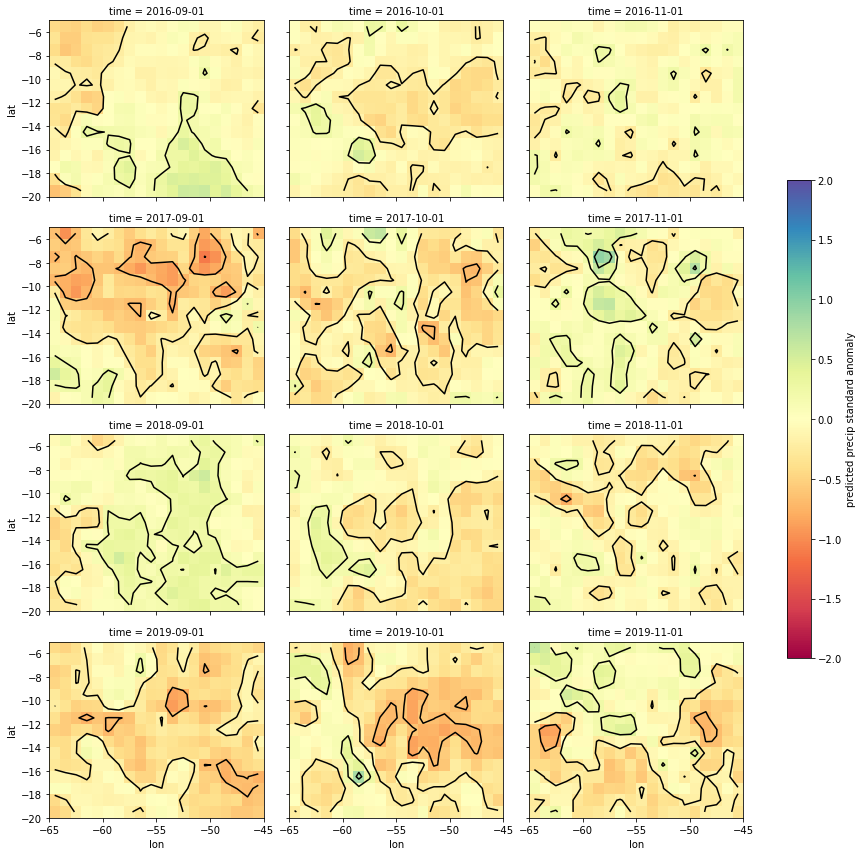

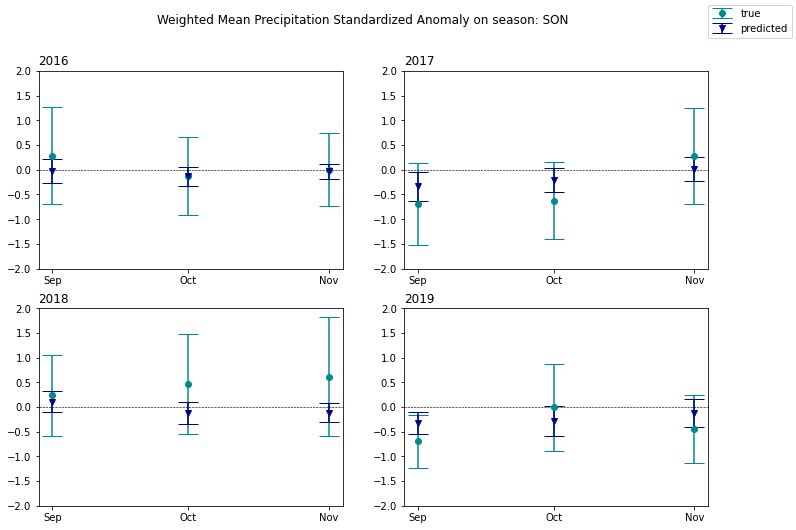

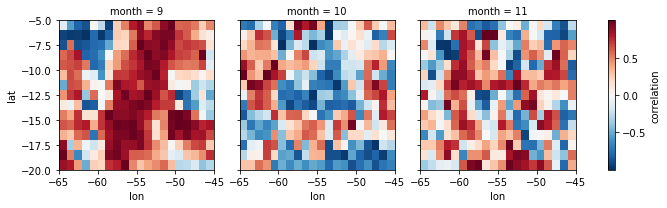

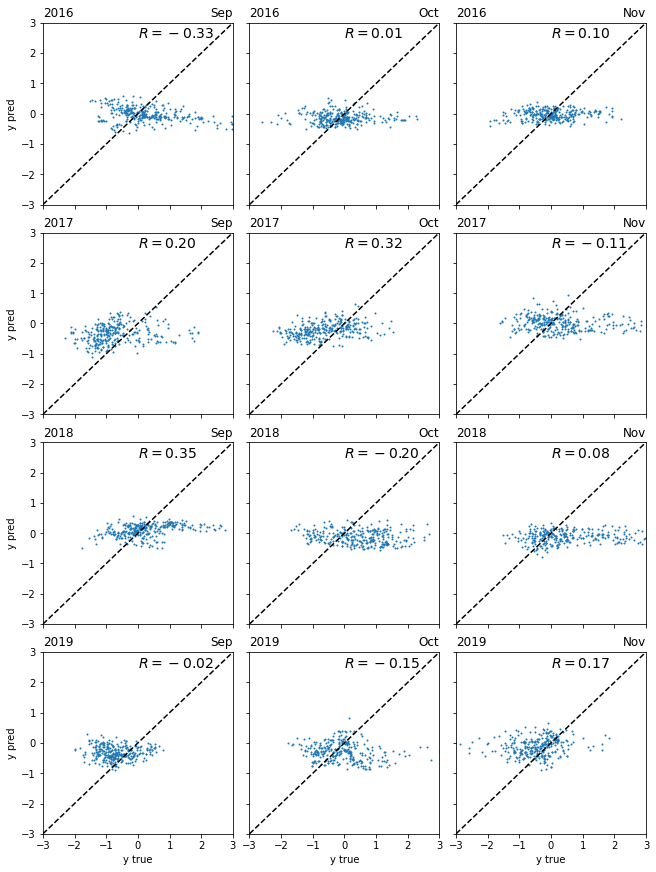

In [28]:
from sklearn.linear_model import Lasso

forecaster = DirectForecaster(Lasso(alpha=0.01),lags=3,target_months=[9,10,11],steps=3,include_autoreg=True,avg_lags=True,pca_features=True)
X_train,y_train,X_test,y_test = forecaster.train_test_split(4,data.target_da,data.features_da)
forecaster.fit(X_train,y_train)

y_pred = forecaster.predict(X_test,y_test)
weights = np.abs(np.cos(np.deg2rad(y_test.lat.values)))

print('mean absolute error on the test set: {:.3f}'.format(mean_absolute_error(y_test,y_pred,multioutput=weights)))

y_true_ds = get_dataset(y_test)
y_pred_ds = get_dataset(y_pred)
forecaster.data_plots(y_true_ds,y_pred_ds,model_name='lasso',forecaster_name='direct',individual=True,plot_facet=True,plot_timeseries=True,plot_corr_map=True,plot_error=True)

## Neural Network Regression
Direct forecasting using a neural network with 1 hidden layer with 5 nodes

mean absolute error on the test set: 0.729


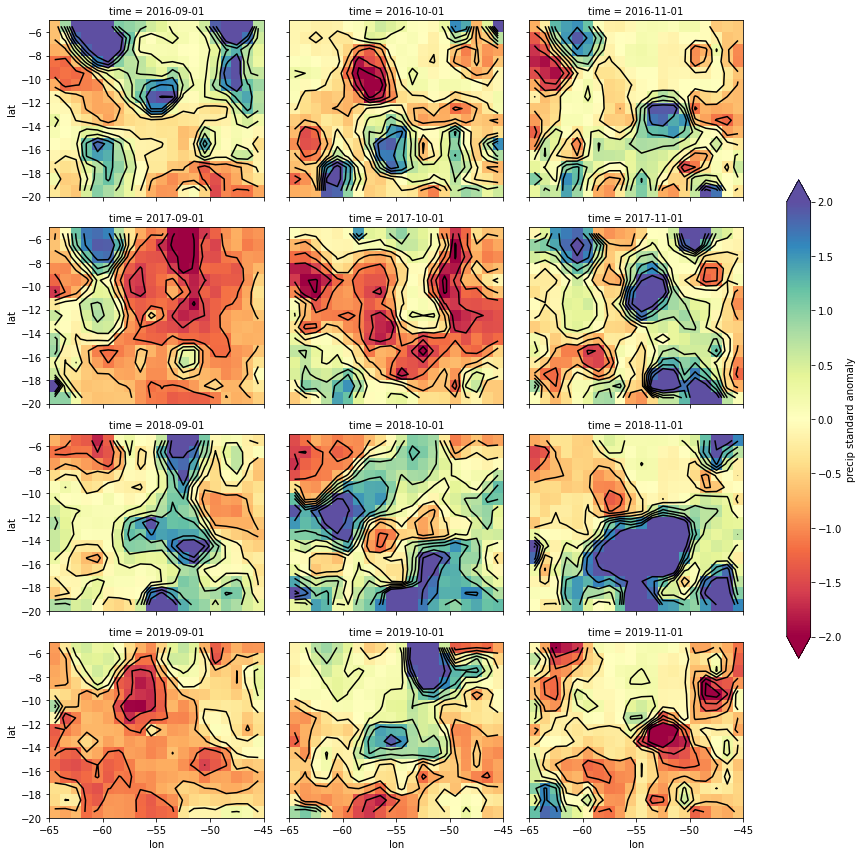

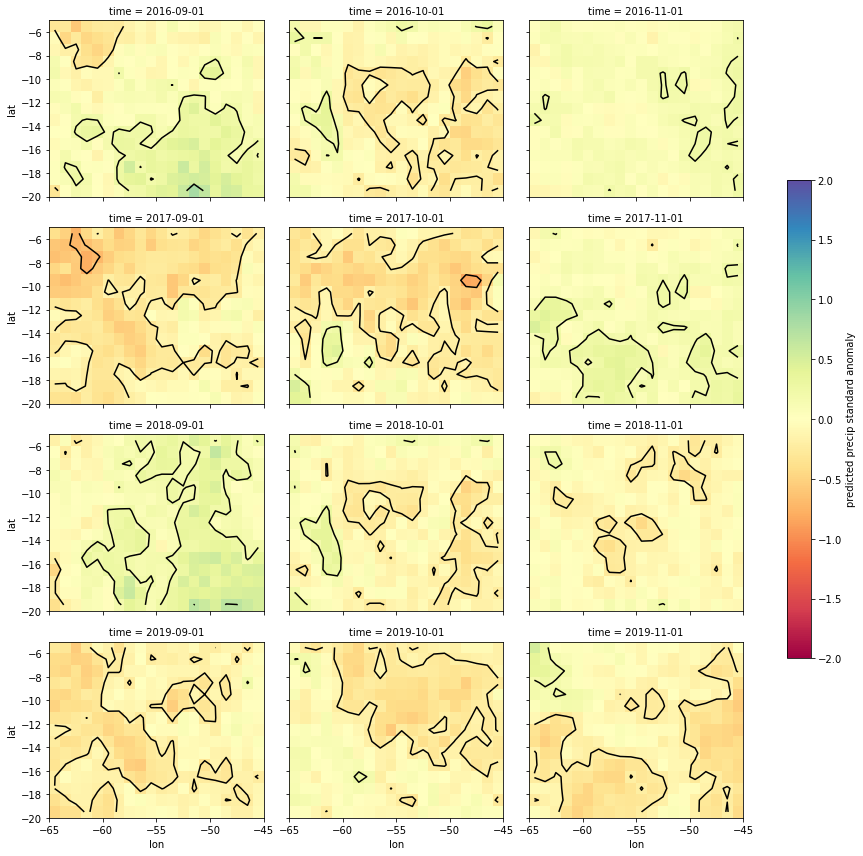

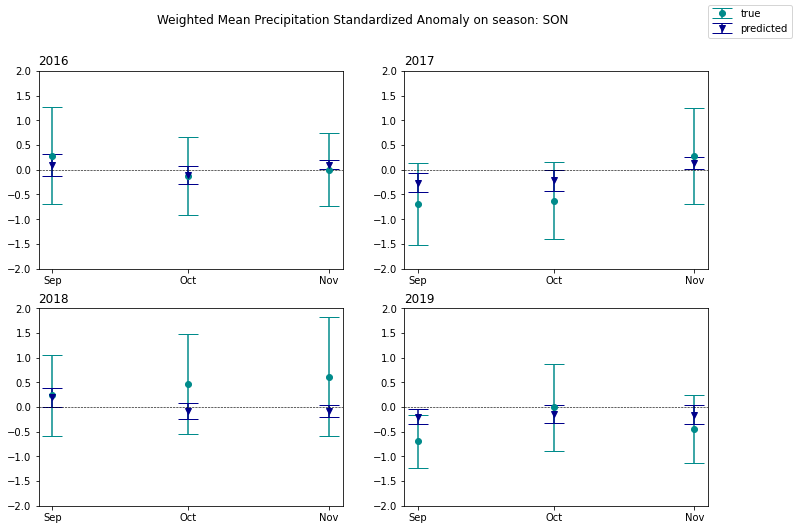

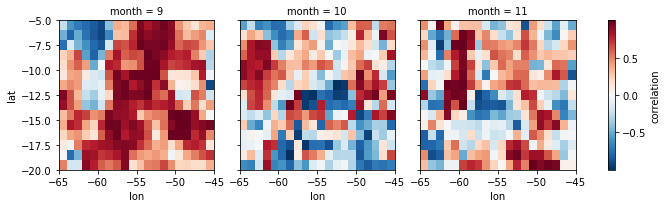

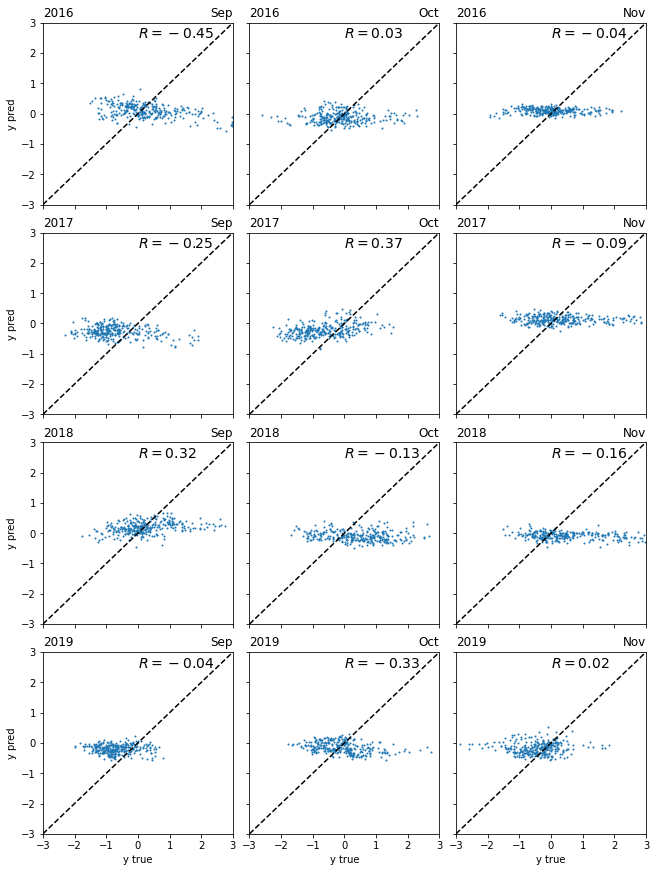

In [23]:
from sklearn.neural_network import MLPRegressor

forecaster = DirectForecaster(MLPRegressor((5,),max_iter=1000),lags=3,target_months=[9,10,11],steps=3,include_autoreg=True,avg_lags=True,pca_features=True)
X_train,y_train,X_test,y_test = forecaster.train_test_split(4,data.target_da,data.features_da)
forecaster.fit(X_train,y_train)

y_pred = forecaster.predict(X_test,y_test)
weights = np.abs(np.cos(np.deg2rad(y_test.lat.values)))

print('mean absolute error on the test set: {:.3f}'.format(mean_absolute_error(y_test,y_pred,multioutput=weights)))

y_true_ds = get_dataset(y_test)
y_pred_ds = get_dataset(y_pred)
forecaster.data_plots(y_true_ds,y_pred_ds,model_name='neural_network',forecaster_name='direct_pca',individual=True,plot_facet=True,plot_timeseries=True,plot_corr_map=True,plot_error=True)